2017 Edition

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [94]:
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from operator import add

In [129]:
def euclidean_distance(p1, p2):
    return math.sqrt(__builtin__.sum([ (p1[i] - p2[i])*(p1[i] - p2[i]) for i in range(len(p1))]))

# test our function
assert (np.round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

In [130]:
# calculate distance between two d-dimensional points
def euclidean_distanceB(p1, p2):
    return np.linalg.norm([p1[i]-p2[i] for i in range(len(p1))])

# test our function
assert (np.round(euclidean_distanceB([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

<div class="alert alert-warning">

K-means algorithm uses euclidean distance to calculate the 'closeness' of data points. Other algorithms are used in similar methods to K-means, such as Manhattan norm in K-medoids.

</div>

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [121]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    index=0
    mindist=euclidean_distance(datapoint, centroids[0])
    for i in range(1, len(centroids)):
        dist=euclidean_distance(datapoint, centroids[i])
        if(dist < mindist):
            mindist= dist
            index=i
    return index

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"




def find_closest_centroidB(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    distances = [euclidean_distance(datapoint, centroid) for centroid in centroids]
    return distances.index(__builtin__.min(distances))

assert(find_closest_centroidB( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"




from operator import itemgetter

def find_closest_centroidC(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    return __builtin__.min(enumerate([euclidean_distance(datapoint, centroid) for centroid in centroids]), key=itemgetter(1))[0]

assert(find_closest_centroidC( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"


In [128]:
t0 = time.time()
for i in range(1000000):
    a= find_closest_centroid( [1,1,1], [ [i,1,2], [i,2,1], [i,1,2] ] )
t1 = time.time()
for i in range(1000000):
    b= find_closest_centroidB( [1,1,1], [ [i,1,2], [i,2,1], [i,1,2] ] )
t2 = time.time()
for i in range(1000000):
    c= find_closest_centroidC( [1,1,1], [ [i,1,2], [i,2,1], [i,1,2] ] )
t3 = time.time()
for i in range(1000000):
    d= find_closest_centroid( [1,1,1], [ [i,1,2], [i,2,1], [i,1,2] ] )
t4 = time.time()

print(t1-t0)
print(t2-t1)
print(t3-t2)
print(t4-t3)

7.7223334312438965
7.715105056762695
8.98439359664917
7.599747896194458


<div class="alert alert-warning">

We tried several approaches to optimize the functions above, as they are repeated a huge amount of times in the K-means algorithm. Optimizing their running time will result in significant improvements in the algorithm's running time. To our surprise, for the closest cluster's index, the iterative loop method kept consistently returning the best results.

</div>

<div class="alert alert-warning">

We found that choosing the random centers at the beginning has a huge impact on clustering, especially for the first dataset 'iris' whose data points weren't well clustered most of the time.
<br>
The number of iterations also has an impact on the results since the more we iterate, the more accurate the results would be. But that can't be done forever because it's computationally costly. That's why there was the necessity to define stopping criteria.
<br>
Our algorithm isn't as optimized as the already implemented one in MLLib but in all cases it gave results that look somehow accurate graphically.

</div>

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [10]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    centroids = [data[np.random.randint(0,len(data))] for i in range(k)]
    return centroids

assert(len(
    randomize_centroids(
        np.array([ 
            np.array([2,1,2]), 
            np.array([1,2,1]), 
            np.array([3,1,2]) 
             ]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [11]:
MAX_ITERATIONS = 1000

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if(num_iterations >= MAX_ITERATIONS):
        return True
    # check if the centroids don't move (or very slightly)
    test = True
    for i in range(len(centroids)):
        if(euclidean_distance(centroids[i], old_centroids[i]) > threshold):
            test=False
            break
    return test

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [12]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    for i in range(len(cluster)):
        centroids[i]=np.mean(cluster[i], axis=0)
    return centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [13]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for i in range(len(data)):
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(data[i], centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(data[i])
        
        # keep the current position of centroids before changing them
        old_centroids = centroids
        
        # update centroids
        centroids = update_centroids(centroids, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if (check_converge(centroids, old_centroids, iterations, threshold=0)==True):
            break
    
    return centroids


Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


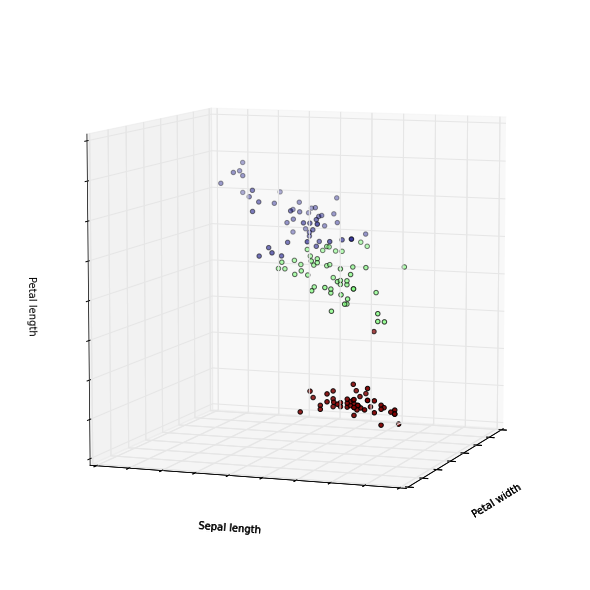

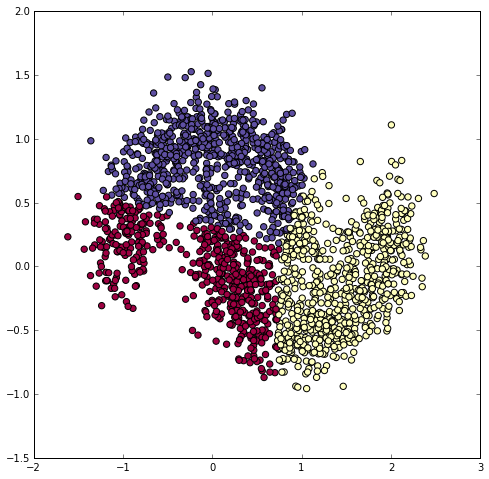

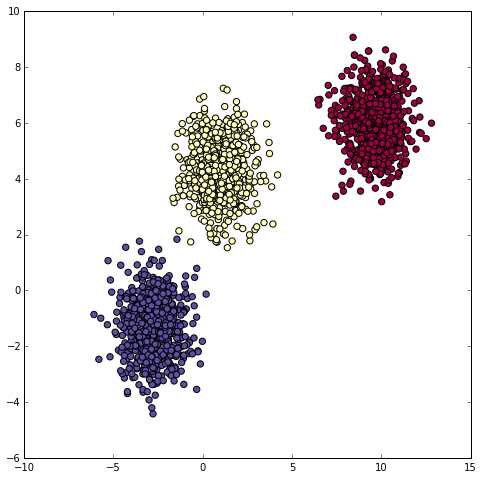

In [14]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

# moon
np.random.seed(0)
X, y = datasets.make_moons(2000, noise=0.2)
fig = plt.figure(2, figsize=(8, 8))
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)



# blob
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)
fig = plt.figure(3, figsize=(8, 8))
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_


<div class="alert alert-warning">

We found that choosing the random centers at the beginning has a huge impact on clustering, especially for the first dataset 'iris' whose data points weren't well clustered most of the time.
<br>
The number of iterations also has an impact on the results since the more we iterate, the more accurate the results would be. But that can't be done forever because it's computationally costly. That's why there was the necessity to define stopping criteria.
<br>
Our algorithm isn't as optimized as the already implemented one in MLLib but in all cases it gave results that look somehow accurate graphically.

</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [15]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

In [16]:
raw_data.take(5)

['0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1,1,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0.00,0.00,0.00,1.00,0.00,0.00,2,2,1.00,0.00,0.50,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,3,3,1.00,0.00,0.33,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.00,0.00,0.00,0.00,1.00,0.00,0.00,4,4,1.00,0.00,0.25,0.00,0.00,0.00,0.00,0.00,normal.']

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [131]:
def parseLine(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector[1:4] = []
    
    # convert each value from string to float
    vector = np.array(vector).astype(np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(lambda line: parseLine(line))

# we only need the data, not the label
data = labelsAndData.map(lambda x: x[1]).cache()

# number of connections
n = data.count()

In [12]:
print('The number of connections:',n)

The number of connections: 4898431


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [47]:
import time

t0 = time.time()

clusters = KMeans.train(data, 2, maxIterations=10, initializationMode="random")

print(time.time()-t0)

9.384139776229858


In [48]:
clusters.centers

[array([  4.83424305e+01,   1.83462118e+03,   1.09362281e+03,
          5.71611604e-06,   6.48779170e-04,   7.96173305e-06,
          1.24376561e-02,   3.20510792e-05,   1.43529020e-01,
          8.08830419e-03,   6.81850985e-05,   3.67464602e-05,
          1.29349582e-02,   1.18874799e-03,   7.43095085e-05,
          1.02114330e-03,   0.00000000e+00,   4.08294003e-07,
          8.35165383e-04,   3.34973440e+02,   2.95267086e+02,
          1.77970281e-01,   1.78036953e-01,   5.76650911e-02,
          5.77301017e-02,   7.89884175e-01,   2.11796063e-02,
          2.82608043e-02,   2.32981083e+02,   1.89214245e+02,
          7.53713236e-01,   3.07111052e-02,   6.05052012e-01,
          6.46410657e-03,   1.78091148e-01,   1.77885862e-01,
          5.79278038e-02,   5.76594138e-02])]

# Selecting three features:

In [198]:
sampleData = data.map(lambda x : [x[1], x[1], x[32], clusters.predict(x)]).takeSample(False,  2000, 1)

In [199]:
sampleData[0:5]

[[336.0, 336.0, 0.02, 0],
 [520.0, 520.0, 1.0, 0],
 [1032.0, 1032.0, 1.0, 0],
 [1032.0, 1032.0, 1.0, 0],
 [520.0, 520.0, 1.0, 0]]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


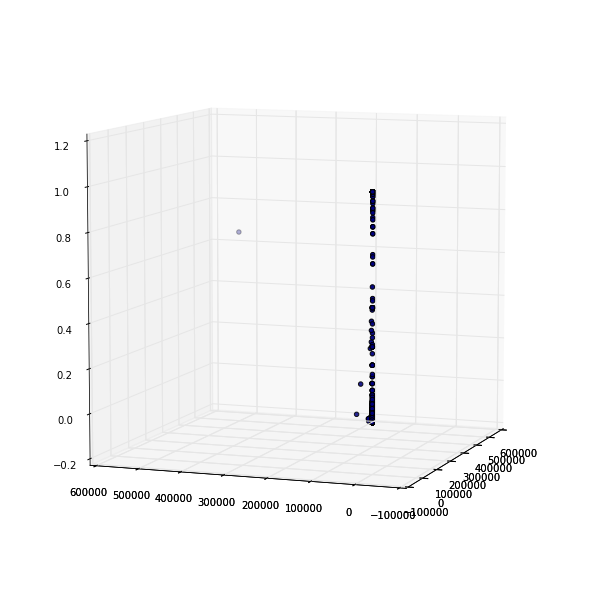

In [200]:
centers = clusters.centers
sampleData = np.array(sampleData).T
labels = sampleData[3]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(sampleData[0], sampleData[1], sampleData[2], c=labels)




plt.show()


# Applying PCA:

In [192]:
sampleData = np.array(data.takeSample(False, 4000, 1))

In [196]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=3).fit(sampleData).transform(sampleData)
pca2 = PCA(n_components=2).fit(sampleData).transform(sampleData)

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


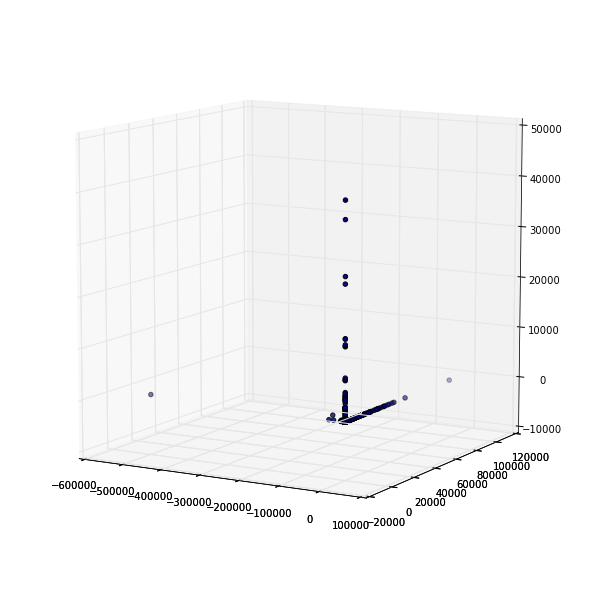

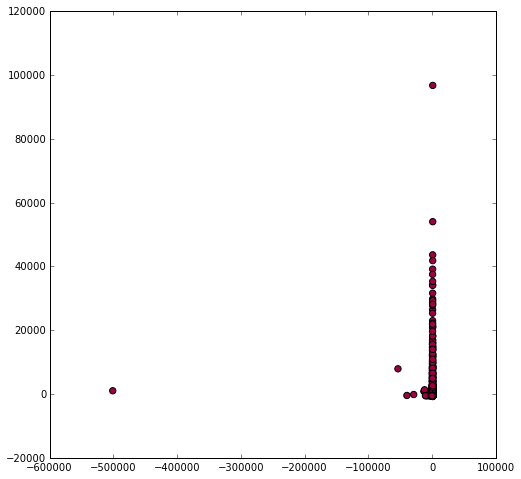

In [197]:
centers = clusters.centers
pca1 = np.array(pca1).T
pca2 = np.array(pca2).T
labels = [clusters.predict(point) for point in sampleData]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=10, azim=300)
plt.cla()
ax.scatter(pca1[0], pca1[1], pca1[2], c=labels)

plt.figure(2, figsize=(8, 8))
plt.clf()
plt.scatter(pca2[0], pca2[1], s=40, c=labels, cmap=plt.cm.Spectral)


plt.show()

<div class="alert alert-warning">


The first choice of K = 2 probably was to have anomalous and non-anomalous connections a part but that wasn't correct since each anomaly can be so different than the others. So they wouldn't really belong to the same cluster but they can be outliers to some clusters that are formed of the non-anomalous connections.
<br>
To plot the clustering results, it's not possible directly with 38 dimensions (the number of features) so we tried to find another way to do so. 
<br>
We considered: dimensionality reduction.
We had either to make random Projections, Feature agglomeration or PCA (principal component analysis).
<br>
We tried to plot the clustering results using three features that we chose at the beginning with 2000 samples and the results were quite logical since we have just 5 elements in cluster number 1, we found visually one of cluster 1 points away from the other cluster.
<br>
We also applied PCA on a sample of 4000 points and printed two different plots: 2D and 3D. In the 2D plot, we didn't really see two clusters, maybe because just 5 elements in one cluster is a so low number or the implementation of the PCA isn't totally correct. And for the 3D one, probably the representation wasn't appropriate enough for our dataset or the clustering using the given features wasn't correct.

</div>

<div class="alert alert-warning">

We wanted to gain understanding of the underlying data. However, since our eyesight only enables us to perceive three dimensions (fourth with color), we had to think of an alternative way than just one feature per dimension.
<br><br>
We came up with the idea, that maybe seeing the distribution of each feature in one-dimension would be useful, since we could then identify if its all clamped up, linearly spread or perhaps clustered into several centers. The below plots show each feature as an x-axis index, and their respective 1-d plot in y-axis.
<br><br>
The three plots differ only in the area plotted, the last one being most zoomed in.
</div>

In [132]:
tobeplot = np.array(normalizedData.takeSample(False, 2000, 1337)).T
indexed = [[[y,i] for y in x ] for i, x in enumerate(tobeplot)]
flattened = [item for sublist in indexed for item in sublist]
y = np.array(flattened).T[0]
x = np.array(flattened).T[1]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


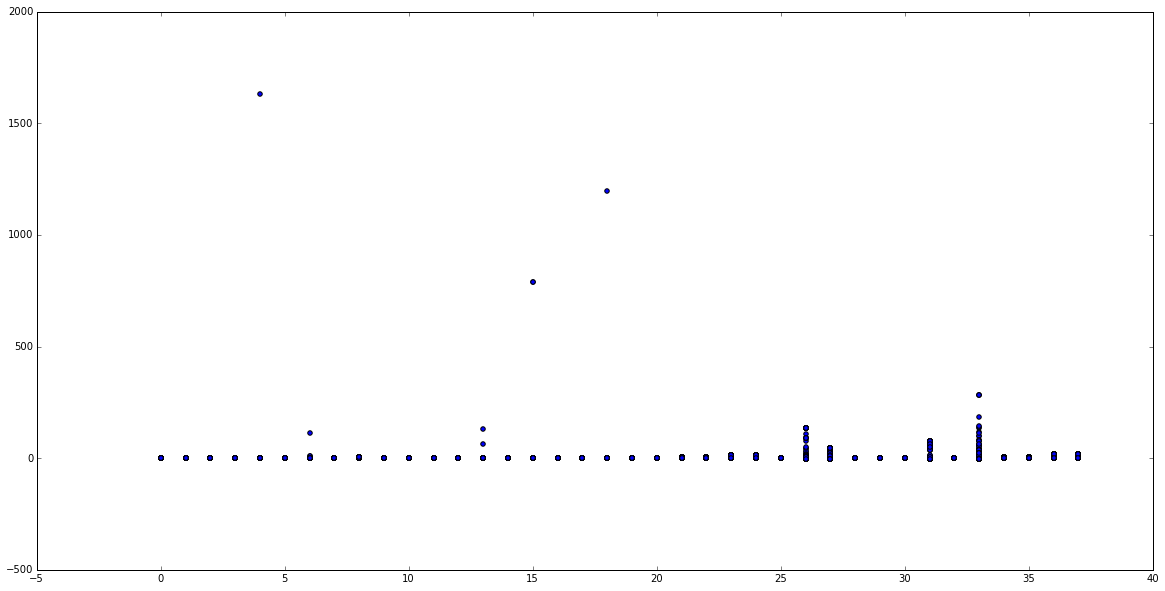

In [73]:
plt.figure(figsize=(20,10))
plt.scatter(x,y)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


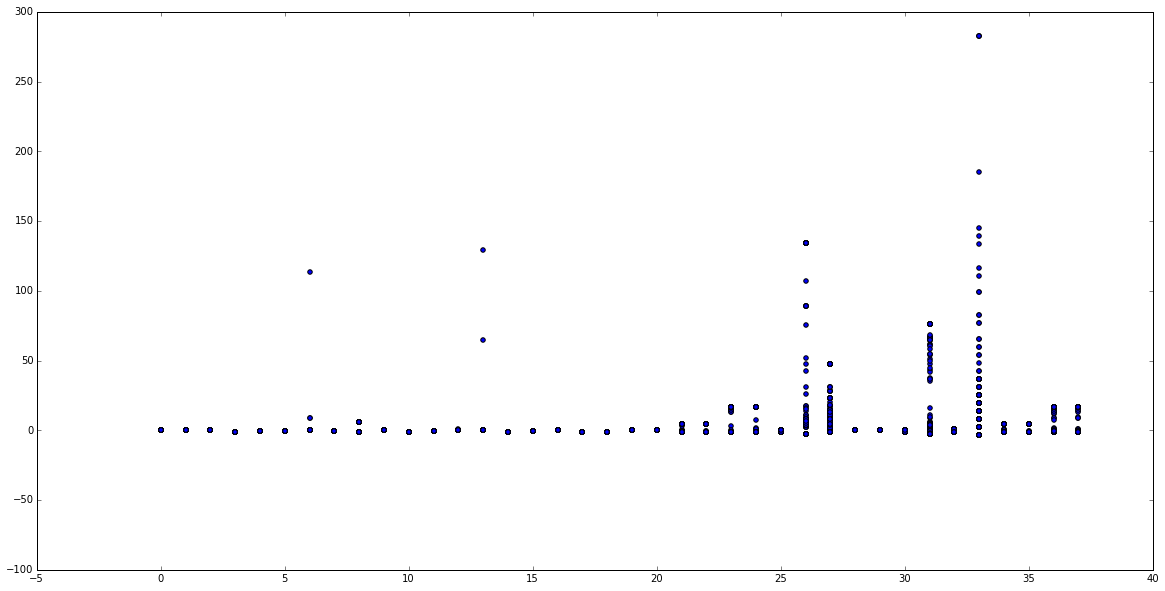

In [74]:
plt.figure(figsize=(20,10)) 
plt.ylim(-100, 300)
plt.scatter(x,y)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


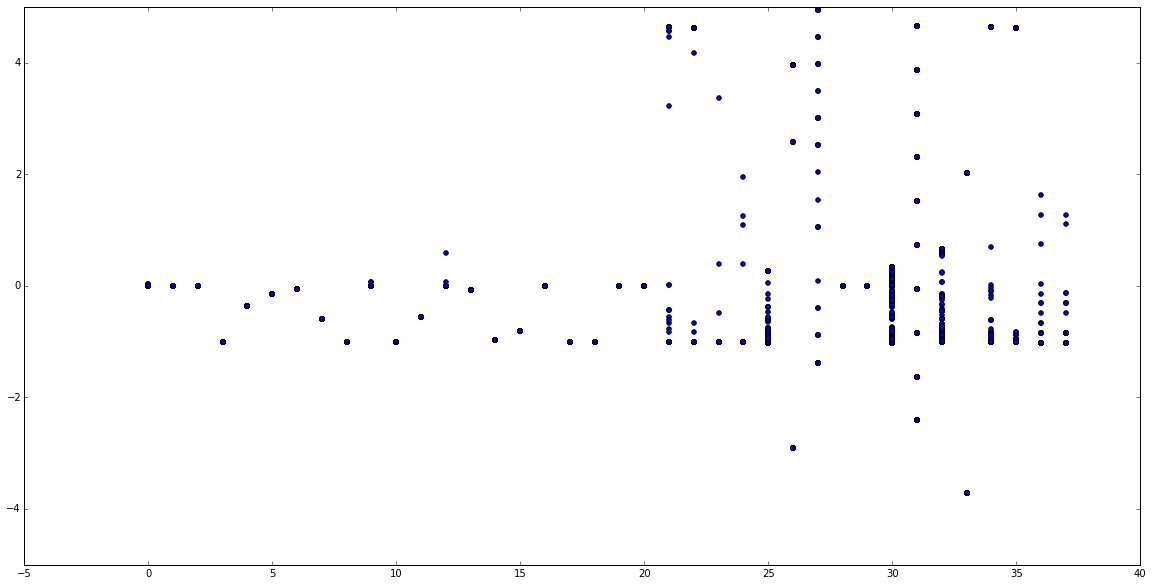

In [75]:
plt.figure(figsize=(20,10))
plt.ylim(-5, 5)
plt.scatter(x,y)
plt.show()

### 2.2.3. Evaluating model

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [21]:
from operator import add
import time

t0 = time.time()

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = find_closest_centroid(point, clusters)
    return euclidean_distance(point, clusters[closest_center])

WSSSE = data.map(lambda p : error(clusters.centers, p)**2).reduce(add)

t1 = time.time()


print("Within Set Sum of Squared Error = " + str(WSSSE))
print("WSSSE using the ready-made method:", clusters.computeCost(data))
print("Time: ", t1-t0)

Within Set Sum of Squared Error = 3.05254895755e+18
WSSSE using the ready-made method: 3.052548957548266e+18
Time:  28.789783477783203


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [22]:
labels = labelsAndData.map(lambda x: x[0])
clusterLabelCount = data.map(lambda x: clusters.predict(x)).zip(labels).map(lambda x: (x,1)).reduceByKey(lambda x, y: x + y).collect()

In [23]:
for item in clusterLabelCount:
    print(item)

((0, 'nmap.'), 2316)
((0, 'ftp_write.'), 8)
((0, 'smurf.'), 2807886)
((0, 'pod.'), 264)
((0, 'normal.'), 972781)
((0, 'teardrop.'), 979)
((0, 'rootkit.'), 10)
((0, 'phf.'), 4)
((0, 'multihop.'), 7)
((0, 'perl.'), 3)
((1, 'portsweep.'), 5)
((0, 'land.'), 21)
((0, 'spy.'), 2)
((0, 'warezclient.'), 1020)
((0, 'back.'), 2203)
((0, 'ipsweep.'), 12481)
((0, 'guess_passwd.'), 53)
((0, 'buffer_overflow.'), 30)
((0, 'satan.'), 15892)
((0, 'loadmodule.'), 9)
((0, 'imap.'), 12)
((0, 'neptune.'), 1072017)
((0, 'warezmaster.'), 20)
((0, 'portsweep.'), 10408)


<div class="alert alert-warning">

As a result of clustering, we had two clusters: one of them contains 5 connections and the other contains the rest 4898426.
This could have been kind of correct if we had the whole labeled connections 'portsweep.' included in just one cluster and not in both. Then we would have said that our clustering succeeded to separate 'portsweep.' from the other data and that the rest had all the same label. <br>
But since we have 23 different labels, splitting them into 2 clusters isn't practical. We should choose a convenient number of clusters in order to get well clustered results.

</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

In [24]:
# k: the number of clusters
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, initializationMode="random")
    # calculate mean square error
    
    return clusters.computeCost(data)/data.count()

In [27]:
scores=[]
for k in range(10,120,5):
#for k in range(10,15,5):
    t0 = time.time()
    a = clusteringScore(data, k)
    t1 = time.time()
    t=t1-t0
    print("K: %3d      Score: %12d      Time: %4.2f" %(k, a, t))
    scores.append((k,a,t))

K:  10      Score: 237362874928      Time: 10.41
K:  15      Score: 223404110827      Time: 11.90
K:  20      Score: 233015763281      Time: 10.62
K:  25      Score: 202968412745      Time: 11.43
K:  30      Score: 202971828345      Time: 10.76
K:  35      Score: 202967084644      Time: 12.11
K:  40      Score: 202302858965      Time: 10.76
K:  45      Score: 202275959577      Time: 10.98
K:  50      Score: 202221424089      Time: 11.98
K:  55      Score: 197218976545      Time: 12.37
K:  60      Score: 202207379016      Time: 11.50
K:  65      Score: 202212434905      Time: 12.04
K:  70      Score: 202206118288      Time: 11.63
K:  75      Score: 202245824740      Time: 13.65
K:  80      Score: 202893598387      Time: 12.01
K:  85      Score: 202210995017      Time: 12.16
K:  90      Score: 202199082139      Time: 11.83
K:  95      Score: 202203547532      Time: 13.33
K: 100      Score: 197201459187      Time: 13.91
K: 105      Score: 197230290057      Time: 13.28
K: 110      Score: 1

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


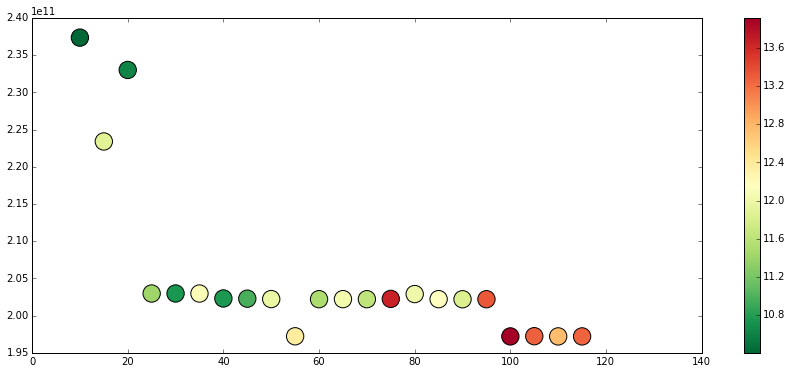

In [28]:
#Plot the results:

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,6))


ks, ss, ts = np.array(scores).T

sc = plt.scatter(ks, ss, c=ts, s=300, cmap='RdYlGn_r')

plt.colorbar(sc)
plt.show()

<div class="alert alert-warning">

We had almost the same score in five cases: k in {55, 100, 105, 110, 115} but the best was for the case of k=100.<br>
In general, the results of clustering depend on the initial random choice of centers. So results vary each time even for the same chosen K. But also, the more we increase the number of clusters, the better the score will be since the distortion will be smaller in smaller clusters. But that becomes more computationally expensive. So according to the Elbow method, k=100 should be the most appropriate.

</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [136]:
from operator import add
def normalizeData(data):
    # number of connections
    n = data.count()

    # calculate the sum of each feature
    sums = data.reduce(add)
    print(sums)

    # calculate means
    means = [sums[i]/n for i in range(len(sums))]

    # calculate the sum square of each feature
    sumSquares = data.map(lambda x: x**2).reduce(add)
    print(sumSquares)

    # calculate standard deviation of each feature
    stdevs = [sumSquares[i]/n for i in range(len(sumSquares))]
    print(stdevs)

    def normalize(point):
        return [(point[i]-means[i])/stdevs[i] if (stdevs[i] != 0) else (point[i]-means[i]) for i in range(len(point))]

    return data.map(normalize)

normalizedData = normalizeData(data).cache()
print(normalizedData.take(5))

[  2.36802060e+08   8.98676524e+09   5.35703589e+09   2.80000000e+01
   3.17800000e+03   3.90000000e+01   6.09250000e+04   1.57000000e+02
   7.03067000e+05   3.96200000e+04   3.34000000e+02   1.80000000e+02
   6.33610000e+04   5.82300000e+03   3.64000000e+02   5.00200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   1.64084428e+09
   1.44634545e+09   8.71775140e+05   8.72101730e+05   2.82468470e+05
   2.82786920e+05   3.86919313e+06   1.03746840e+05   1.38433600e+05
   1.14124176e+09   9.26852923e+08   3.69201228e+06   1.50436230e+05
   2.96380553e+06   3.16639800e+04   8.72367200e+05   8.71361620e+05
   2.83755350e+05   2.82440660e+05]
[  2.57433563e+12   4.34145810e+18   2.03795314e+18   2.80000000e+01
   8.99800000e+03   2.55000000e+02   1.07812100e+06   2.61000000e+02
   7.03067000e+05   7.28519560e+07   3.34000000e+02   3.20000000e+02
   7.59678130e+07   7.55510000e+04   3.74000000e+02   6.18200000e+03
   0.00000000e+00   2.00000000e+00   4.09100000e+03   7.69775149e+1

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [30]:
normscores=[]
for k in range(10,120,5):
#for k in range(10,15,5):
    t0 = time.time()
    a = clusteringScore(normalizedData, k)
    t1 = time.time()
    t=t1-t0
    print("K: %3d      Score: %12d      Time: %4.2f" %(k, a, t))
    normscores.append((k,a,t))


K:  10      Score:       217111      Time: 93.13
K:  15      Score:      2488121      Time: 32.95
K:  20      Score:        51501      Time: 29.03
K:  25      Score:        39527      Time: 30.37
K:  30      Score:        66718      Time: 35.58
K:  35      Score:        24049      Time: 33.08
K:  40      Score:        65849      Time: 30.03
K:  45      Score:        52104      Time: 38.22
K:  50      Score:        51356      Time: 36.50
K:  55      Score:        36894      Time: 28.86
K:  60      Score:        25463      Time: 31.22
K:  65      Score:        37805      Time: 35.64
K:  70      Score:        27230      Time: 32.46
K:  75      Score:        36576      Time: 30.44
K:  80      Score:        38066      Time: 30.91
K:  85      Score:        23594      Time: 39.51
K:  90      Score:        22534      Time: 41.94
K:  95      Score:        12235      Time: 30.30
K: 100      Score:        37075      Time: 30.56
K: 105      Score:        27835      Time: 33.65
K: 110      Score:  

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


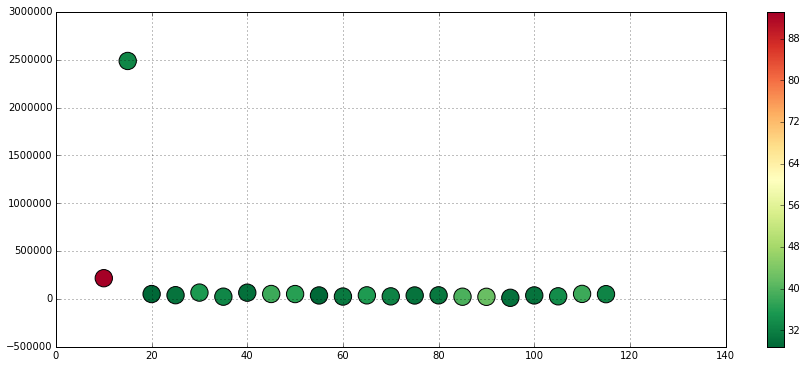

In [31]:
#Plot the results:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,6))


ks, ss, ts = np.array(normscores).T

sc = plt.scatter(ks, ss, c=ts, s=300, cmap='RdYlGn_r')

plt.grid()
plt.colorbar(sc)
plt.show()

<div class='alert alert-warning'>

The best result was in the case of k=95. And the values of the score are smaller than before since we normalized the data.

</div>

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

In [72]:
tobeplot = np.array(data.takeSample(False, 2000, 1337)).T
indexed = [[[y,i] for y in x ] for i, x in enumerate(tobeplot)]
flattened = [item for sublist in indexed for item in sublist]
y = np.array(flattened).T[0]
x = np.array(flattened).T[1]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


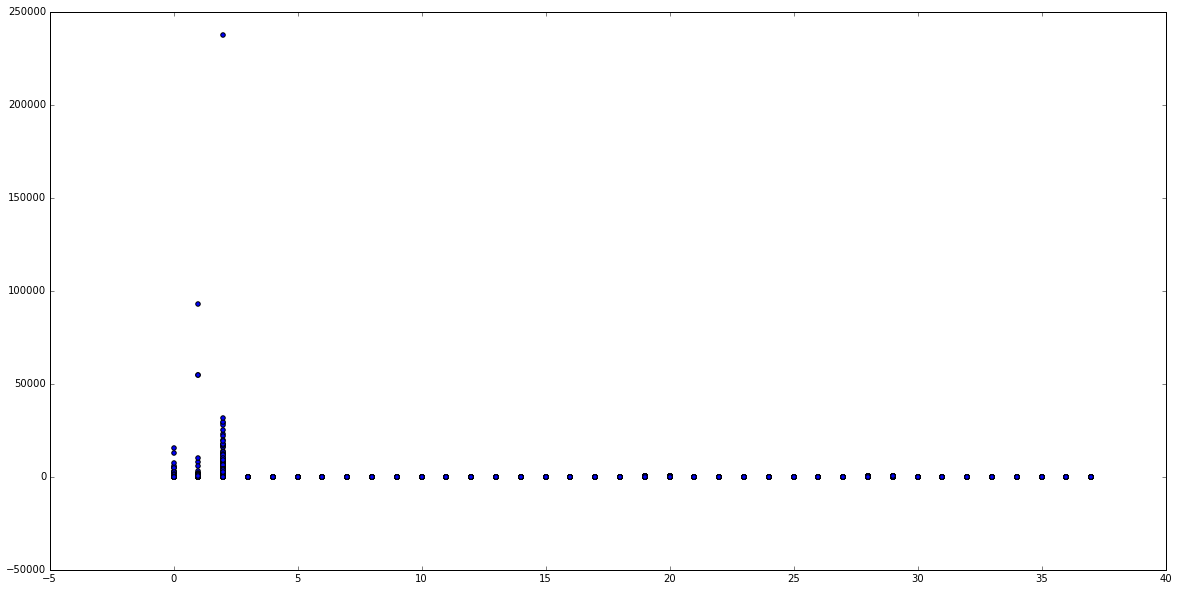

In [134]:
plt.figure(figsize=(20,10))
plt.scatter(x,y)
plt.show()

In [137]:
tobeplot = np.array(normalizedData.takeSample(False, 2000, 1337)).T
indexed = [[[y,i] for y in x ] for i, x in enumerate(tobeplot)]
flattened = [item for sublist in indexed for item in sublist]
y = np.array(flattened).T[0]
x = np.array(flattened).T[1]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


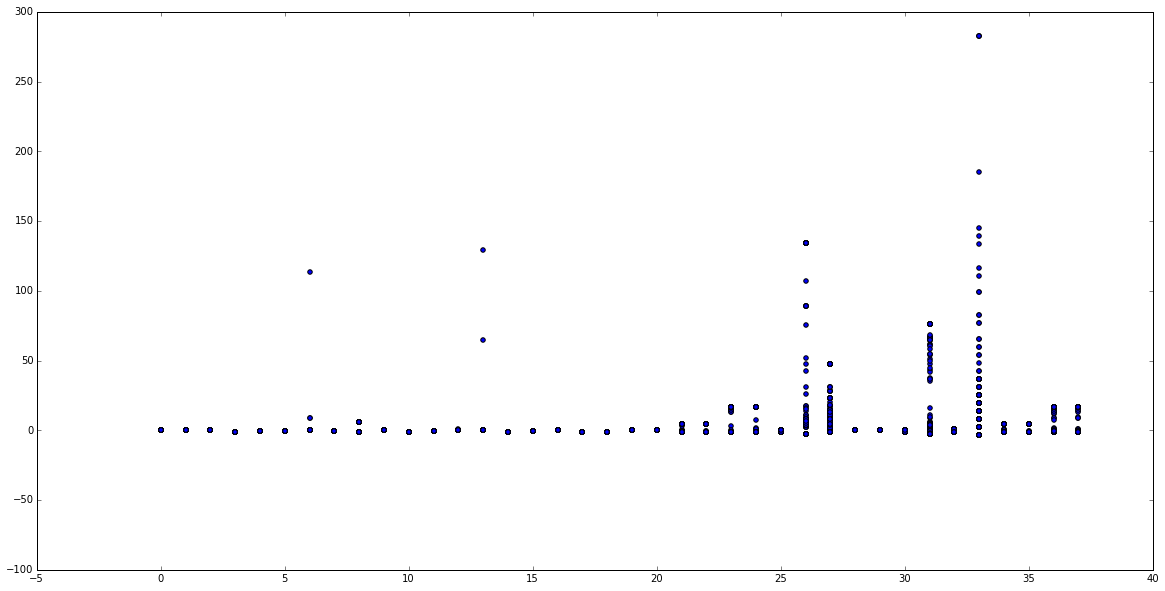

In [138]:
plt.figure(figsize=(20,10))
plt.ylim(-100, 300)
plt.scatter(x,y)
plt.show()

In [201]:
clustersOriginal = KMeans.train(data, 95, maxIterations=10, initializationMode="random")

In [202]:
clustersNormalized = KMeans.train(normalizedData, 95, maxIterations=10, initializationMode="random")

In [209]:
sampleDataOriginal = np.array(data.takeSample(False, 4000, 1))

In [210]:
sampleDataNormalized = np.array(normalizedData.takeSample(False, 4000, 1))

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


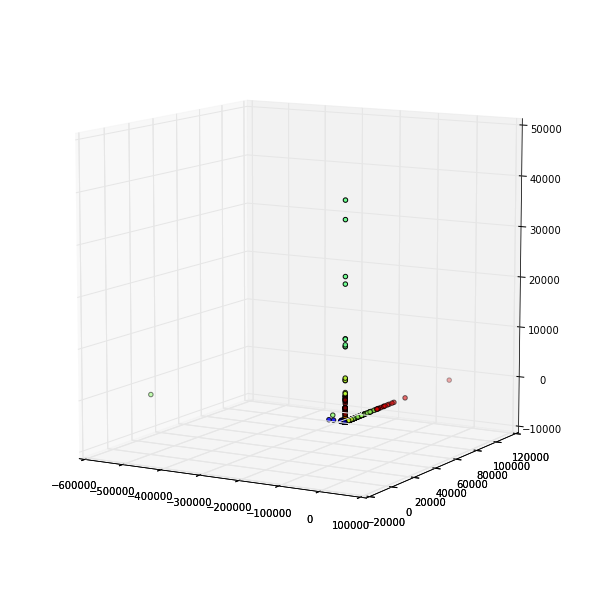

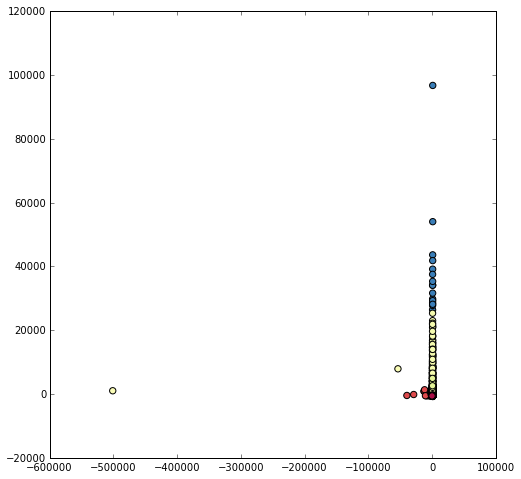

In [212]:
pca1 = PCA(n_components=3).fit(sampleDataOriginal).transform(sampleDataOriginal)
pca2 = PCA(n_components=2).fit(sampleDataOriginal).transform(sampleDataOriginal)

centers = clustersOriginal.centers
pca1 = np.array(pca1).T
pca2 = np.array(pca2).T
labels = [clustersOriginal.predict(point) for point in sampleDataOriginal]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=10, azim=300)
plt.cla()
ax.scatter(pca1[0], pca1[1], pca1[2], c=labels)

plt.figure(2, figsize=(8, 8))
plt.clf()
plt.scatter(pca2[0], pca2[1], s=40, c=labels, cmap=plt.cm.Spectral)


plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


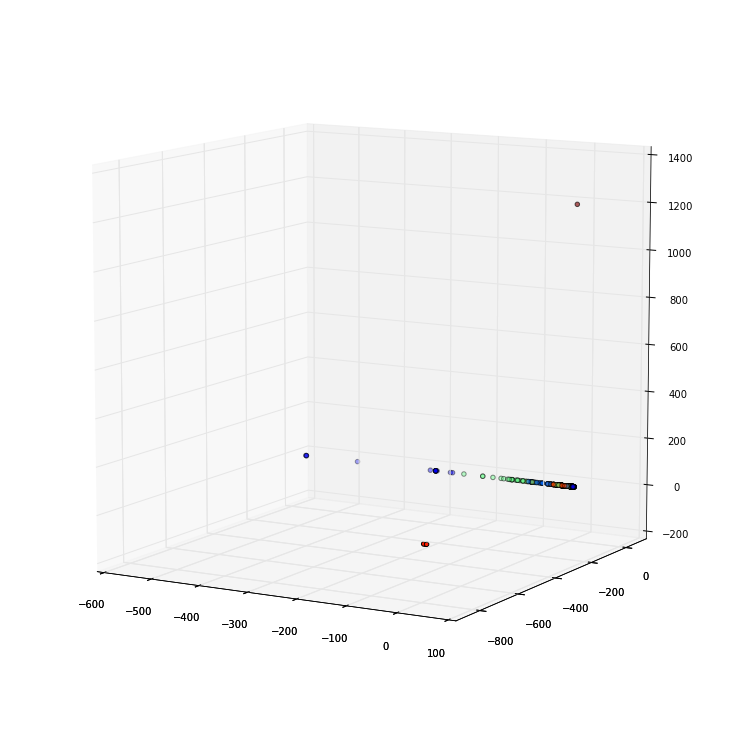

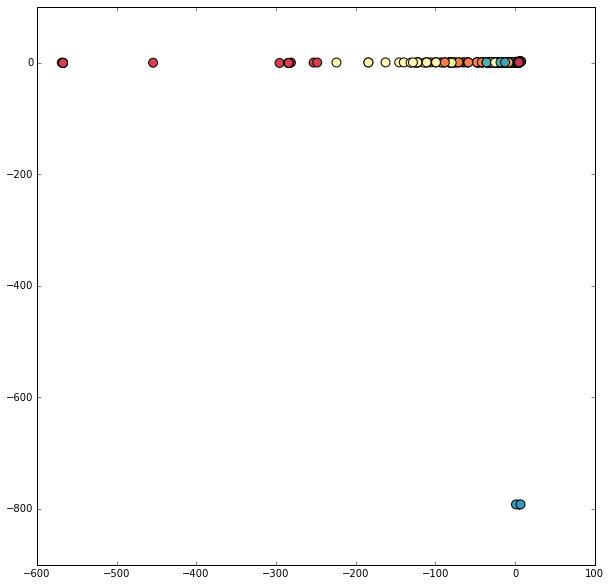

In [218]:
pca1 = PCA(n_components=3).fit(sampleDataNormalized).transform(sampleDataNormalized)
pca2 = PCA(n_components=2).fit(sampleDataNormalized).transform(sampleDataNormalized)

centers = clustersNormalized.centers
pca1 = np.array(pca1).T
pca2 = np.array(pca2).T
labels = [clustersNormalized.predict(point) for point in sampleDataNormalized]

#plot the clusters in color
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=10, azim=300)
plt.cla()
ax.scatter(pca1[0], pca1[1], pca1[2], c=labels)

plt.figure(2, figsize=(10, 10))
plt.clf()
plt.scatter(pca2[0], pca2[1], s=80, c=labels, cmap=plt.cm.Spectral)


plt.show()

<div class="alert alert-warning">


Normalizing the data reduced the distance between the values of each feature. The usefulness of the normalization of data depends whether there's big variation between the values of the feature or not which is the case for some features of our dataset (the first 2 figures represent the variation of the values of each feature in a 2000-point sample in both cases Original and Normalized data). So the normalization improved our dataset.<br>
It's not obvious in the last 4 plots (2D and 3D representations of clustering the original and normalized datasets) but it should have an effect since it reduced the WSSSE very much.

</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [32]:
cols = raw_data.map(lambda x: x.split(","))
c1 = cols.map(lambda x: x[1]).distinct().count()
c2 = cols.map(lambda x: x[2]).distinct().count()
c3 = cols.map(lambda x: x[3]).distinct().count()

print("The number of categorical features at index: \n1: %d \n2: %d \n3: %d" %(c1, c2, c3))

The number of categorical features at index: 
1: 3 
2: 70 
3: 11


In [33]:
d1 = {x:i for i,x in enumerate(cols.map(lambda x: x[1]).distinct().collect())}
d2 = {x:i for i,x in enumerate(cols.map(lambda x: x[2]).distinct().collect())}
d3 = {x:i for i,x in enumerate(cols.map(lambda x: x[3]).distinct().collect())}

In [34]:
def parseLineWithHotEncoding(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0] * c1
    featureOfCol1[d1[cols[1]]] = 1
    print(featureOfCol1)
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = [0] * c2
    featureOfCol2[d2[cols[2]]] = 1
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = [0] * c3
    featureOfCol3[d3[cols[3]]] = 1
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector).astype(np.float)
    
    return (label, vector)


labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
data = labelsAndData.values().cache()


normalizedDataWHE = normalizeData(data).cache()

[  2.36802060e+08   1.94288000e+05   1.87059800e+06   2.83354500e+06
   1.07300000e+03   1.98100000e+03   2.00000000e+00   1.05700000e+03
   1.05600000e+03   2.81166000e+06   7.26530000e+04   3.00000000e+00
   1.05300000e+03   1.57900000e+03   1.07300000e+03   6.23091000e+05
   1.07800000e+03   5.21400000e+03   1.05200000e+03   1.04000000e+03
   1.06700000e+03   1.04100000e+03   5.77820000e+04   1.05900000e+03
   1.04500000e+03   1.63380000e+04   1.05600000e+03   1.00000000e+00
   1.05200000e+03   1.10083100e+06   1.03800000e+03   6.89100000e+03
   1.05600000e+03   1.05500000e+03   1.04500000e+03   5.37800000e+03
   1.05200000e+03   5.21000000e+02   4.06970000e+04   1.05400000e+03
   1.04400000e+03   1.48000000e+02   1.04700000e+03   1.06800000e+03
   1.05000000e+03   1.11300000e+03   1.05000000e+03   1.05600000e+03
   1.07500000e+03   1.05900000e+03   1.04500000e+03   1.06900000e+03
   2.00000000e+00   1.07600000e+03   1.20000000e+01   1.07000000e+03
   1.05100000e+03   1.05100000e+03

### 2.3.2. Building models

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [35]:
import time
normscores=[]
for k in range(10,200,10):
#for k in range(10,20,10):
    t0 = time.time()
    a = clusteringScore(normalizedDataWHE, k)
    t1 = time.time()
    t=t1-t0
    print("K: %3d      Score: %12d      Time: %4.2f" %(k, a, t))
    normscores.append((k,a,t))

K:  10      Score:     18889939      Time: 296.04
K:  20      Score:     13848097      Time: 78.74
K:  30      Score:     13840427      Time: 86.37
K:  40      Score:     13433400      Time: 87.88
K:  50      Score:     12449068      Time: 80.57
K:  60      Score:     15638618      Time: 84.58
K:  70      Score:     13769917      Time: 80.30
K:  80      Score:     10918097      Time: 84.13
K:  90      Score:     13666793      Time: 93.38
K: 100      Score:     11489582      Time: 84.15
K: 110      Score:     11607903      Time: 95.64
K: 120      Score:     13673431      Time: 94.14
K: 130      Score:     12552446      Time: 88.00
K: 140      Score:      7693433      Time: 101.63
K: 150      Score:     12732594      Time: 93.11
K: 160      Score:     12399693      Time: 87.96
K: 170      Score:     12321638      Time: 92.02
K: 180      Score:      9038747      Time: 89.39
K: 190      Score:      9829025      Time: 92.66


/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


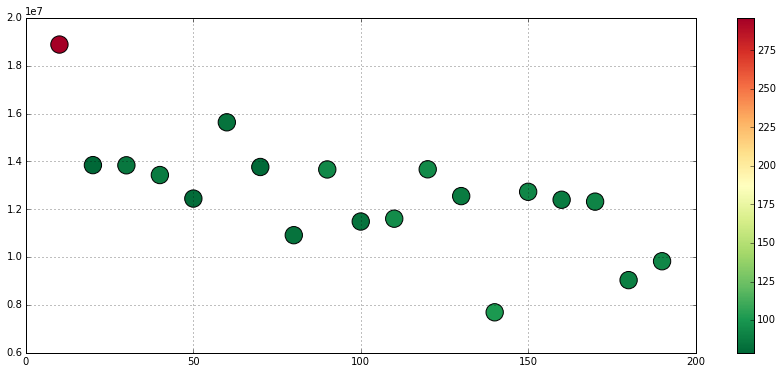

In [36]:
#Plot the results:

import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15,6))


ks, ss, ts = np.array(normscores).T

sc = plt.scatter(ks, ss, c=ts, s=300, cmap='RdYlGn_r')

plt.grid()
plt.colorbar(sc)
plt.show()

In [38]:
print(clusteringScore(normalizedDataWHE, 140))

12316787.21109125


<div class="alert alert-warning">


The best result was for k = 80 most of the time but the results differ each time we retry to cluster since the random initial centers have a big impact. For example we found this time the best result for k = 140 but it's not the case when we retry to cluster with the same number.


</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [16]:
import time
t0 = time.time()
clusters = KMeans.train(normalizedDataWHE, 80, maxIterations=10, initializationMode="random")
t1 = time.time()
t=t1-t0
print("K: 80      Time: %4.2f" %t)

K: 80      Time: 252.44


In [23]:
dists = normalizedDataWHE.map(lambda x: euclidean_distance(clusters.centers[clusters.predict(x)], x))

In [24]:
threshold = dists.top(100)[-1]
threshold

85438.520497294448

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- [Silhouette](https://en.wikipedia.org/wiki/Silhouette_(clustering))
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

<h2> SILHOUETTE example for one point:

<div class="alert alert-warning">

Silhouette is a method running in O(n^2) time, so it is not scaleable. Implementing it on our rather big dataset would take a lot more computational resources than what we have at hand. We have instead here shown an example of running it on a single point, from where it could easily be extended for larger scale use if it was meaningful.

</div>

In [18]:
clusteredData = normalizedDataWHE.map(lambda x: (x, clusters.predict(x)))
point1 = clusteredData.take(1)
point1

[([-9.1985698025289379e-05,
   -1.0,
   1.6186444121077859,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   6.8615017710093706,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   -1.0,
   0.30822700361720445,
   -1.8274050762855269e-09,
   1.0571618943811158e-07,
   -1.0,
   -0.35318959768837521,
   -0.15294117647058825,
   -0.056510354589141665,
   -0.60153256704980851,
   5.967

In [50]:
distPointClusters = clusteredData.map(lambda x: (x[1], (1, euclidean_distance(point1[0][0],x[0])))).reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).collect()

In [90]:
distToClusters = [(x[0], x[1][1]/x[1][0]) for x in distPointClusters]
sortedDistToClusters = sorted(distToClusters, key=lambda x: x[1])

In [105]:
if(sortedDistToClusters[0][0]==point1[0][1]):
    a=sortedDistToClusters[0][1]
    b=sortedDistToClusters[1][1]
else:
    b=sortedDistToClusters[0][1]
    a=[sortedDistToClusters[i][1] for i in range(len(sortedDistToClusters)) if sortedDistToClusters[i][0]==point1[0][1]][0]
maxAB = a if a>b else b 
s= (b - a)/ maxAB
print("Silhouette of this point is: s = ", s)

Silhouette of this point is: s =  -0.0207212773688


<h2> SILHOUETTE-ISH Hack for all data:

<div class="alert alert-warning">

We decided to experiment what would happen if we implement a version of silhouette that was based on the cluster centers and not each point of a cluster. Here we end up having the ratio of the distance to the point's own cluster compared to the next nearest cluster.
<br>
This runs in ~O(n) time instead of proper Silhouette's O(n^2) time.
<br>
In the end, this implementation ends up being quite far away from the actual Silhouette, as by definition this can only return values between [0,1], as the next nearest cluster center can never be nearer than the cluster a point belongs to. Whileas Silhouette is returning values between [-1,1]. Furthermore, since this implementation is our own idea, we do not have a clear image if the scale of the values we receive indicate a good or a bad result.

</div>

In [20]:
def sil(centers, point):
    a,b = sorted([euclidean_distance(x,point) for x in centers])[:2]
    s = ( b - a ) / b
    return s

In [23]:
print(sil(clusters.centers, normalizedDataWHE.take(1)[0]))

0.193859742265


In [24]:
sils = normalizedDataWHE.map(lambda x: sil(clusters.centers, x))

In [28]:
sortedsils = sils.sortBy(lambda x: x)

In [39]:
plotsils = sortedsils.zipWithIndex().filter(lambda x: x[1] % 10000 == 0).map(lambda x: x[0]).collect()

In [40]:
x = np.linspace(0,1,len(plotsils))

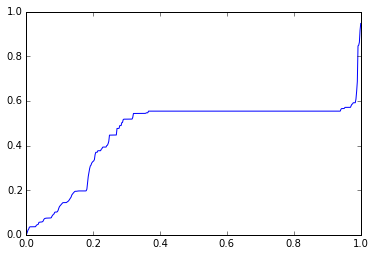

In [41]:
import matplotlib.pyplot as plt

plt.plot(x, plotsils)

![](https://farm2.staticflickr.com/1604/24934700445_833f0a5649_t.jpg)

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

In [17]:
# randomize initial centroids spark version

def randomize_centroids_spark(datardd, k):
    ### .takeSample(replacement, number of samples, seed)
    centroids = datardd.takeSample(False, k, 1337)
    return centroids

In [89]:
import operator

# data : rdd of data points
# k : number of clusters
# centroids: initial list of centroids
# runs: max iterations

def kmeans_spark(data, k=2, centroids=None, runs=2):
    
    # randomize the centroids if they are not given
    if not centroids:
        bcentroids = sc.broadcast(randomize_centroids_spark(data, k))
    else:
        bcentroids = sc.broadcast(centroids)
    
    old_centroids = bcentroids.value

    iterations = 0
    while True:
        print("Iteration: ", iterations)
        print("\n\n")
        iterations += 1
        
        
        ### Prints the current cluster center coordinates
        
        print("bcentroids: ", bcentroids.value)
        print("\n\n")
        
        
        
        ### Maps each data point with the index of the closest cluster center, and adds 1 in the end for later division
        
        dataindexed = data.map(lambda x: (find_closest_centroid(x, bcentroids.value), np.array([i for i in x] + [1])))
        
        
        
        ### Sums the features elementwise per each cluster
        
        centerssummed = dataindexed.reduceByKey(add)

        
        
        ### Sums are divided by the count to get mean for each cluster center
        
        futurecenters = [(data[1][:-1]/data[1][-1]).tolist() for data in centerssummed.collect()]
        
        
        ### Old centroids saved
        
        old_centroids = bcentroids.value
        
        
        ### New cenrtoids broadcasted
        
        bcentroids = sc.broadcast(futurecenters)
        
        
        
        

        # Special stop criteria to allow runs to be set from function call
        
        if iterations == runs:
            break
        
        # if the stop criteria are met, stop the algorithm
        
        if (check_converge(bcentroids.value, old_centroids, iterations, threshold=0)==True):
            break
    
    return bcentroids.value


In [86]:
import operator

# data : rdd of data points
# k : number of clusters
# centroids: initial list of centroids
# runs: max iterations

def kmeans_spark(data, k=2, centroids=None, runs=2):
    
    ### converts to np.array, and adds 1 in the end for later calculation of mean
    
    npdata = data.map(lambda x: (0,np.array(x+[1])))
    
    
    ### randomize the centroids if they are not given
    
    if not centroids:
        bcentroids = sc.broadcast(randomize_centroids_spark(data, k))
    else:
        bcentroids = sc.broadcast(centroids)
    
    old_centroids = bcentroids.value

    iterations = 0
    while True:
        print("Iteration: ", iterations)
        print("\n\n")
        iterations += 1
        
        
        ### Prints the current cluster center coordinates
        
        print("bcentroids: ", bcentroids.value)
        print("\n\n")
        
        
        
        ### Maps each data point with the index of the closest cluster center
        
        dataindexed = npdata.map(lambda x: (find_closest_centroid(x[1][:-1], bcentroids.value), x[1]))
        
        
        
        ### Sums the features elementwise per each cluster
        
        centerssummed = dataindexed.reduceByKey(add)

        
        
        ### Sums are divided by the count to get mean for each cluster center
        
        futurecenters = [(x[1][:-1]/x[1][-1]).tolist() for x in centerssummed.collect()]
        
        
        ### Old centroids saved
        
        old_centroids = bcentroids.value
        
        
        ### New cenrtoids broadcasted
        
        bcentroids = sc.broadcast(futurecenters)
        
        
        
        

        # Special stop criteria to allow runs to be set from function call
        
        if iterations == runs:
            break
        
        # if the stop criteria are met, stop the algorithm
        
        if (check_converge(bcentroids.value, old_centroids, iterations, threshold=0)==True):
            break
    
    return bcentroids.value


In [90]:
import time
t0 = time.time()
finalcenters = kmeans_spark(normalizedData, k=5, runs=2)
t1 = time.time()
owntime = t1-t0

Iteration:  0



bcentroids:  [[-9.1985698025289379e-05, -9.0559078405522517e-10, -2.6286354659427788e-09, -1.0, -0.35318959768837521, -0.15294117647058825, -0.056510354589141665, -0.60153256704980851, -1.0, -0.00054384263889908468, -1.0, -0.56250000000000011, -0.00083405059982442822, -0.077073764741697665, -0.97326203208556139, -0.80912326108055643, 0.0, -1.0, -1.0, 0.0011201374300228702, 0.0014606644508489935, -1.0026361466003264, -1.0012464614284045, -1.0069572589231042, -1.0046374561537135, 0.27095349260287394, -2.9051855324455764, -1.3748429350084943, 0.00037717275721897182, 0.0013991151678419095, 0.33410329357257684, -2.4134845382827717, 0.66107043787928033, -3.7061564771107616, -1.0032352122737451, -1.0010293440525131, -1.021830905387622, -1.0173640791115195], [-9.1985698025289379e-05, -1.4832761177417791e-09, -2.6286354659427788e-09, -1.0, -0.35318959768837521, -0.15294117647058825, -0.056510354589141665, -0.60153256704980851, -1.0, -0.00054384263889908468, -1.0, -0.56250000000

In [92]:
distances = normalizedData.map(lambda x:   euclidean_distance(finalcenters[find_closest_centroid(x, finalcenters)], x ))

In [93]:
WSSSE = distances.map(lambda x: x*x).reduce(add)

In [78]:
t0 = time.time()
clusters = KMeans.train(normalizedData, 5, maxIterations=2, initializationMode="random")
t1 = time.time()
libtime = t1-t0

In [ ]:
WSSSEmllib = clusters.computeCost(normalizedData)

In [118]:
print("Own implementation WSSSE: {0:.4e}".format(WSSSE))
print("Lib implementation WSSSE: {0:.4e}\n".format(WSSSEmllib))

print("Own implementation time:  {0:.1f}".format(owntime))
print("Lib implementation time:  {0:.1f}".format(libtime))

Own implementation WSSSE: 1.3267e+13
Lib implementation WSSSE: 1.3268e+13

Own implementation time:  160.4
Lib implementation time:  20.6


<div class="alert alert-warning">

As we can see from the two values WSSSE and WSSSEmllib, our manual implementation returns similar results as the library implementation.
<br><br>
However there is a huge difference in the running time of the approaches. We are not even able to test our own implementation with neither high k's or high iterations, since it would take too long.
<br><br>
The scale of difference is somewhat surprising. We thought that we were able to write rather clean and efficient code, which means that the library approaches are probably able to use somekind of shortcuts that deal with special cases. It seems unlikely to us that the difference could be 8-fold just by optimising the transformations further without skipping any calculations.

</div>